In [100]:
import numpy as np
import math as m
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.interactiveshell import InteractiveShell

from pandas.plotting import scatter_matrix

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import graphviz
import lime
import xgboost as xgb
InteractiveShell.ast_node_interactivity = "all"

In [101]:
def corrHeatMap(data):
    cols = data.columns
    xticks = np.arange(0,len(cols), 1)
    fig, ax = plt.subplots(figsize=(10,10))
    _ = plt.imshow(data.corr())
    _ = plt.colorbar()
    _ = ax.set_xticks(xticks)
    _ = ax.set_yticks(xticks)
    _ = ax.set_xticklabels(data.columns)
    _ = ax.set_yticklabels(data.columns)

def pltHist(data, column, num_bins=50):
    _ = plt.hist(data[column], num_bins, normed=1, facecolor='green', alpha = 0.5)
    _ = plt.xlabel(column)
    _ = plt.title('Histogram of {}'.format(column))
    
def zeroMean(data, column):
    data[column] -= data[column].mean()
    data[column] /= m.sqrt(data[column].std())
    return data

def dropKLargest(data, column, k):
    for i in range(k):
        data_point = data[column].idxmax()
        data.drop([data_point], inplace=True)

        # check this functionality
def dropLargestBound(data, column, bound):
    data_point = data[column].idxmax()
    print(data.iloc[data_point][column])
    while(data.iloc[data_point][column] > bound):
        data.drop([data_point], axis=0, inplace=True)
        data_point = data[column].idxmax()
        print(data_point)

# Assumes id column has already been stripped
def splitData(data):
    labels = data['Y']
    features = data.drop(['Y'], axis=1)
    return features, labels

# Part 3 Feature Engineering
#### Coming back to Part 1
We notice severe outliers in:<br>`F6`<br>`F16`<br>`F20`<br><br>
We notice moderate outliers in:<br>`F3`<br>`F5`<br>`F8`<br>`F18`<br>`F24`<br><br>
We notice odd groupings in <br>`F7`<br>`F10`<br>`F12`<br>`F19`<br>`F22`<br><br>
Lets quickly fix F6, F16, and F20 again.

In [102]:
filename = 'train.csv'
filepath = ''
data = pd.read_csv(filepath + filename)
data.drop(['id'], axis=1, inplace=True)

# Drop empty columns
garbage = ['F25', 'F26', 'F27']
data.drop(garbage, axis=1, inplace=True)

# F6
for i in range(10):
    data_point = data['F6'].idxmax()
    data.drop([data_point], inplace=True)
data.F6 = np.log(data.F6)

# F16
data = data[data.F16 >= 119000]

# F20
data = data[data.F20 != 12]

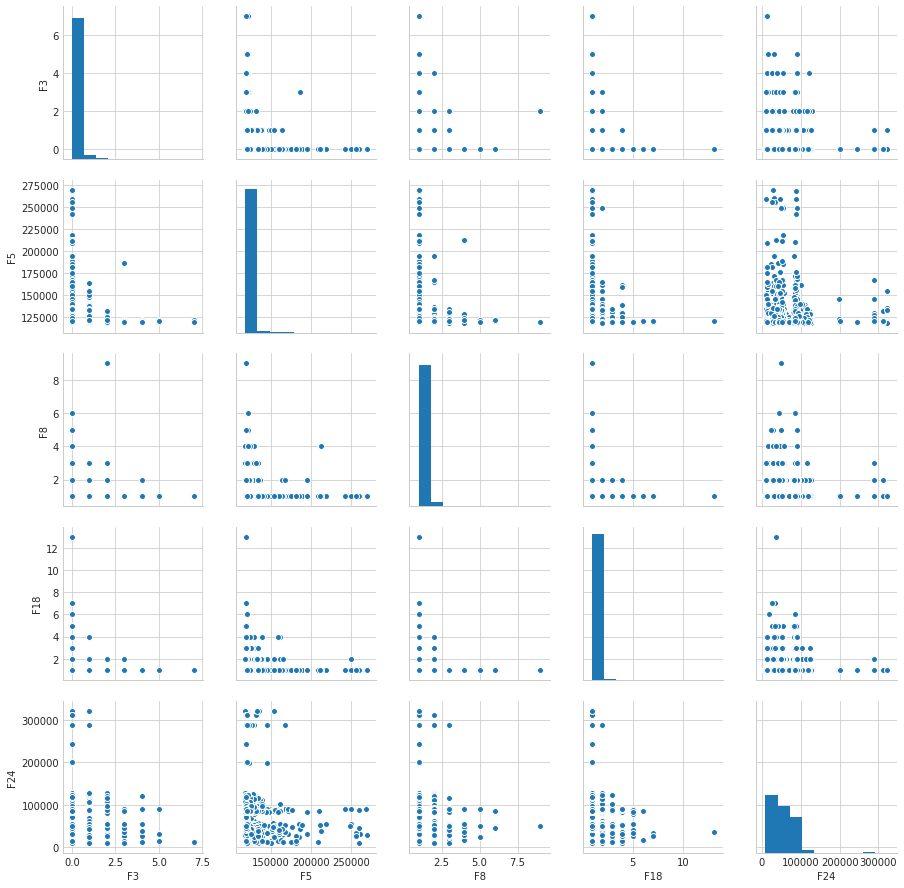

In [103]:
mod_outliers = ['F3', 'F5', 'F8', 'F18', 'F24']
_ = sns.pairplot(data[mod_outliers])

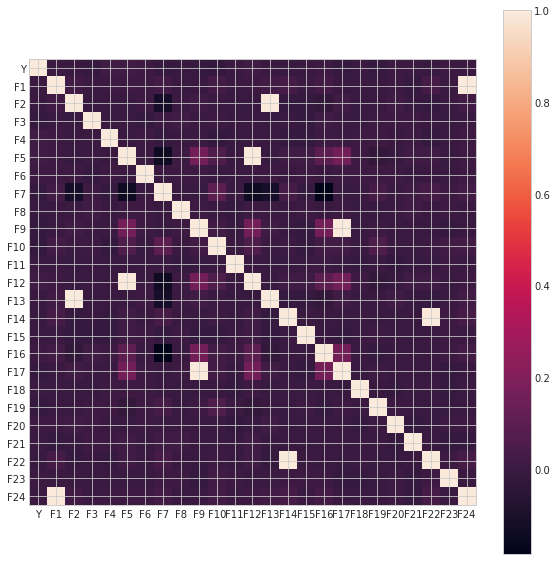

In [104]:
_ = corrHeatMap(data)

In [105]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.017506
F12    0.017506
F4     0.014835
F16    0.011408
F6     0.010885
F20    0.009697
F23    0.006785
F21    0.004126
F18    0.003530
F1     0.002134
F24    0.002134
F11    0.001027
F13   -0.000850
F2    -0.000850
F15   -0.004088
F8    -0.005040
F14   -0.005283
F22   -0.005283
F9    -0.009537
F17   -0.009537
F3    -0.009586
F7    -0.010218
F19   -0.011999
F10   -0.014681
Name: Y, dtype: float64


To be honest this looks like the columns are mostly garbage. I am going to save myself some trouble and drop columns with less than 1 percent correlation to the label.

In [106]:
low_corr = ['F20', 'F23', 'F21', 'F18', 'F1', 'F24', 
            'F11', 'F13', 'F2', 'F15', 'F8', 'F14', 'F22']
data.drop(low_corr, axis=1, inplace=True)

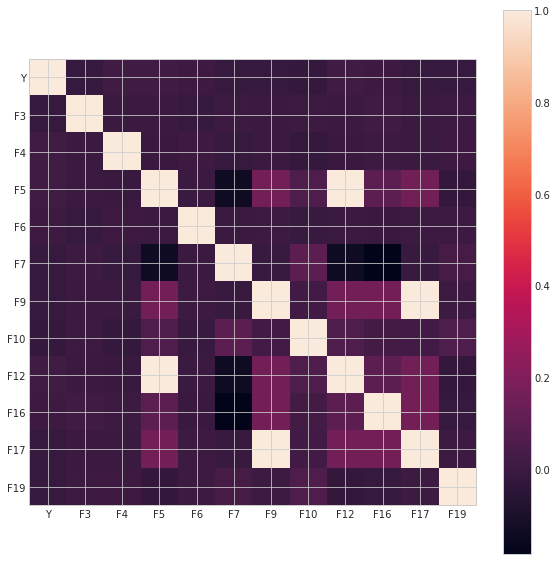

In [107]:
_ = corrHeatMap(data)

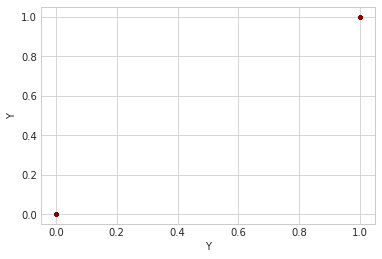

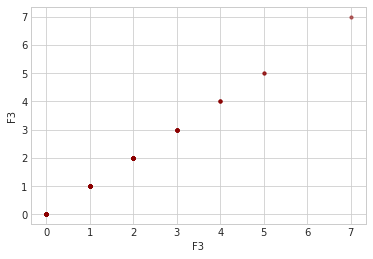

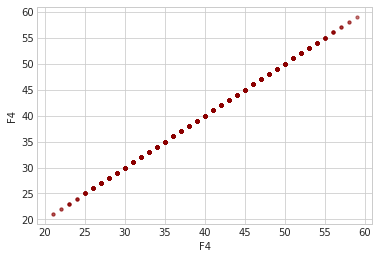

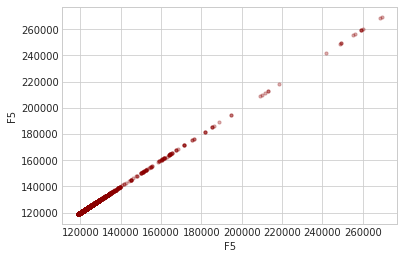

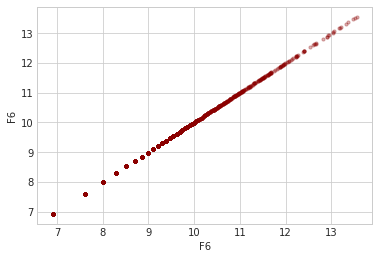

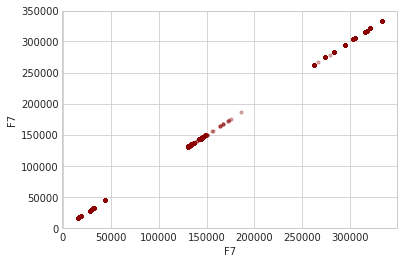

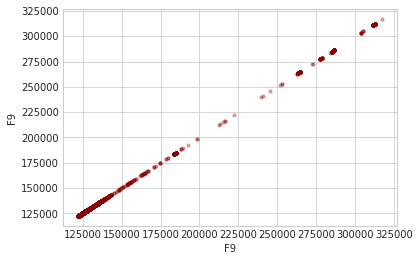

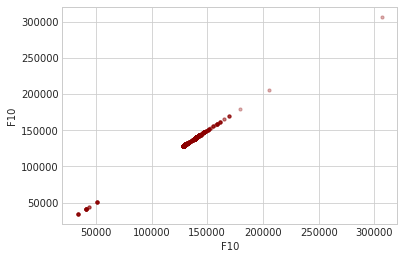

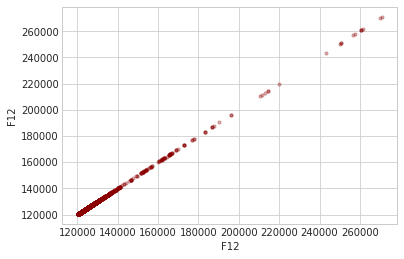

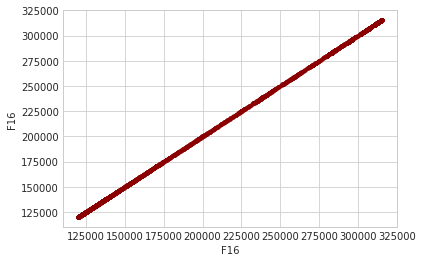

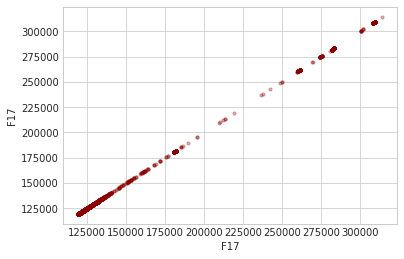

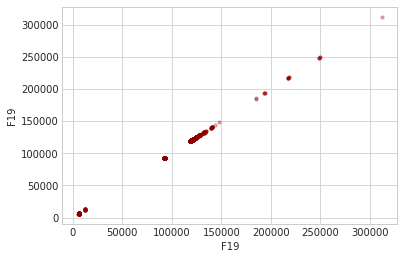

In [108]:
sns.set_style("whitegrid")
for column in data.columns:
    _ = sns.regplot(data[column], data[column], scatter_kws={"color":"darkred","alpha":0.3,"s":10}, fit_reg=False)
    plt.show()

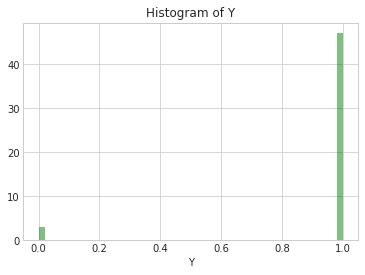

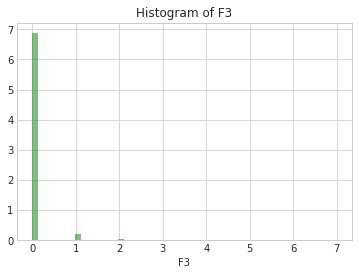

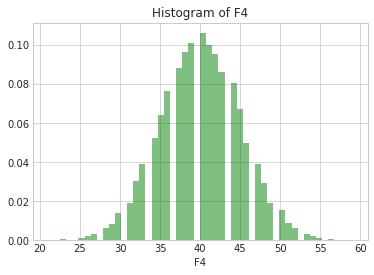

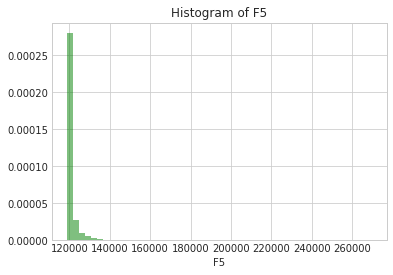

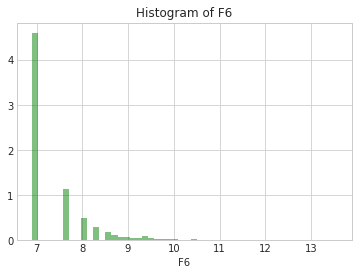

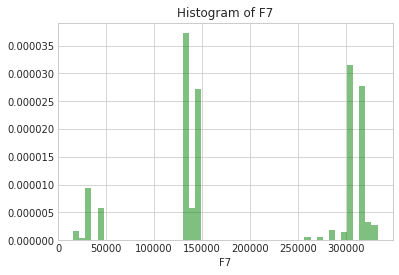

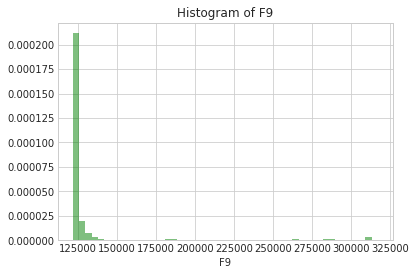

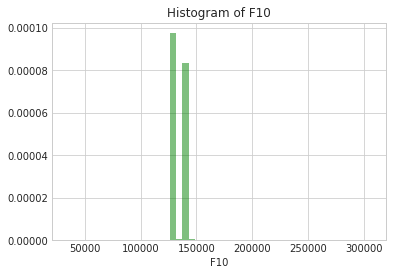

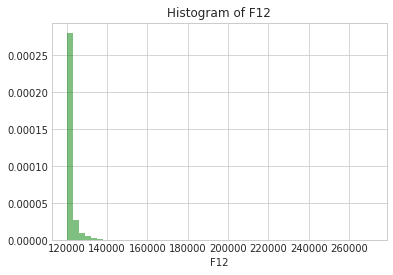

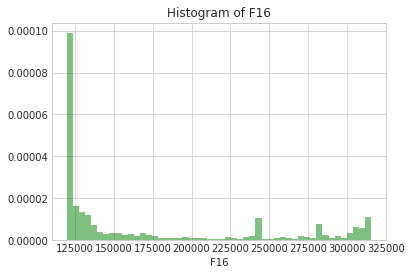

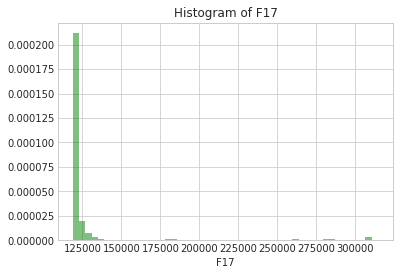

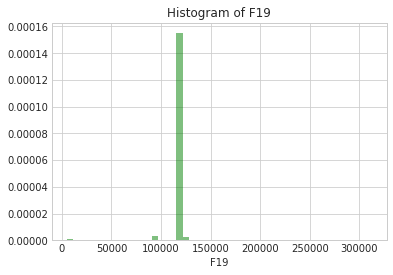

In [109]:
num_bins = 50
for column in data.columns:
    _ = plt.hist(data[column], num_bins, normed=1, facecolor='green', alpha = 0.5)
    _ = plt.xlabel(column)
    _ = plt.title('Histogram of {}'.format(column))
    plt.show()

## Start changing stuff
Let's take them in order.

#### F3

Lets convert it to log data.

In [110]:
data.F3 += 1
data.F3 = np.log(data.F3)

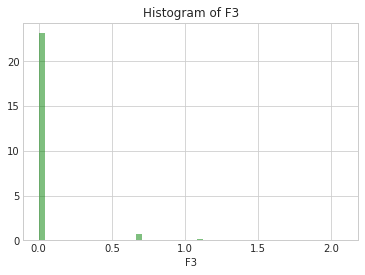

In [111]:
column = 'F3'
pltHist(data, column)

In [167]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.020817
F4     0.015114
F16    0.011068
F6     0.010905
F7     0.003727
F3    -0.012030
F19   -0.012408
F10   -0.018148
F17         NaN
Name: Y, dtype: float64


#### F4

This is obviously normal. Let's leave it in for now, it may make the model more robust to noise. I will convert it to standard normal.

In [112]:
column = 'F4'
data = zeroMean(data, column)

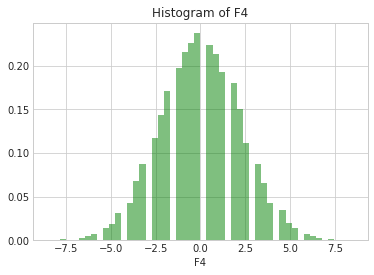

In [113]:
pltHist(data, column)

At least that is scaled. We can remove it later if necessary.

#### F5

Lets look at a log histogram.

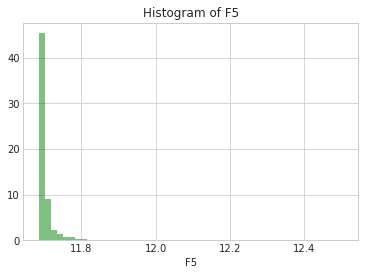

In [114]:
column = 'F5'
_ = plt.hist(np.log(data[column]), num_bins, normed=1, facecolor='green', alpha = 0.5)
_ = plt.xlabel(column)
_ = plt.title('Histogram of {}'.format(column))

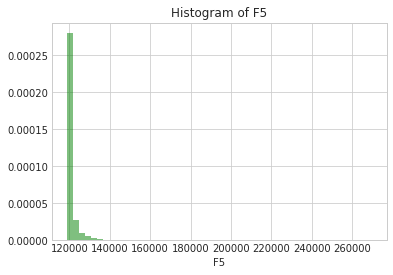

In [115]:
pltHist(data, column)

In [116]:
k = data[data[column] > 180000].count().F5

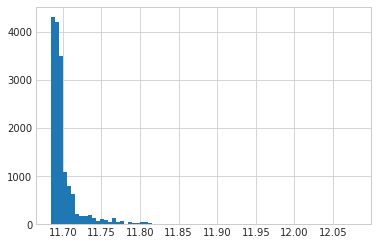

In [117]:
dropKLargest(data, column, k)
_ = plt.hist(np.log(data[column]), bins=75)

In [118]:
data.F5 = np.log(data.F5)

In [119]:
data = zeroMean(data, column)

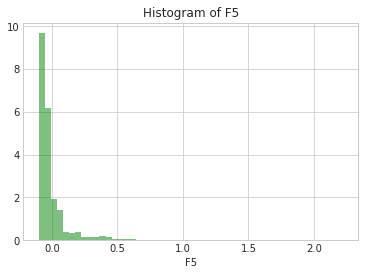

In [120]:
pltHist(data, column)

In [121]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.020867
F12    0.020457
F4     0.015103
F16    0.011235
F6     0.010746
F7    -0.010140
F17   -0.010343
F9    -0.010343
F3    -0.011934
F19   -0.012046
F10   -0.014530
Name: Y, dtype: float64


We improved F5's correlation.

#### F6
This one has some interesting structure, lets zero mean it for now.

In [122]:
column = 'F6'
data = zeroMean(data, column)

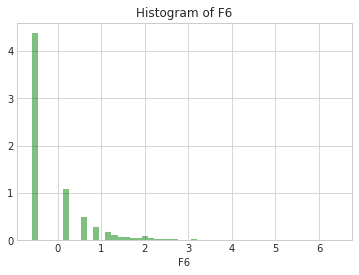

In [123]:
pltHist(data, column)

In [124]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.020867
F12    0.020457
F4     0.015103
F16    0.011235
F6     0.010746
F7    -0.010140
F17   -0.010343
F9    -0.010343
F3    -0.011934
F19   -0.012046
F10   -0.014530
Name: Y, dtype: float64


#### F7
This column is definitely 3 categories. Lets lump them all together.

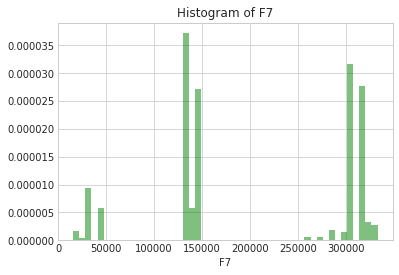

In [125]:
column = 'F7'
pltHist(data, column)

In [126]:
data.loc[data[column] < 75000, column] = 1
data.loc[(data[column] < 215000) & (data[column] > 2), column] = 2
data.loc[data[column] > 215000, column] = 3

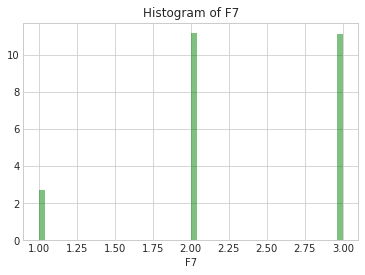

In [127]:
pltHist(data, column)

In [128]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.020867
F12    0.020457
F4     0.015103
F16    0.011235
F6     0.010746
F7     0.003744
F17   -0.010343
F9    -0.010343
F3    -0.011934
F19   -0.012046
F10   -0.014530
Name: Y, dtype: float64


This didnt seem to help. We might as well leave F7 as is, or drop it.

#### F9
F9 is a duplicate of F17. Lets drop it and deal with it at the end.

In [129]:
data.drop('F9', axis=1, inplace=True)

#### F10

F10 is heavily concentrated, but has significant outliers on the 'left' side. Lets drop the ones on the right side.

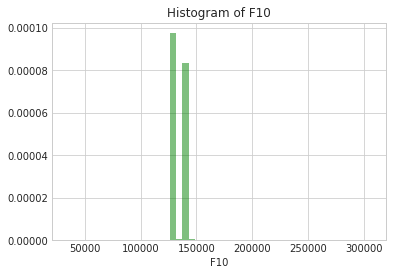

In [130]:
column = 'F10'
pltHist(data, column)
k = data[data[column] > 200000].count().F10

In [131]:
#dropKLargest(data, column, k)

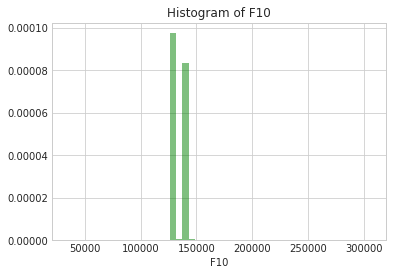

In [132]:
pltHist(data, column)

In [133]:
data[data[column] < 120000].Y

62       1
173      1
208      1
1714     1
1932     1
2022     1
3111     1
3197     1
3723     1
3846     1
4082     1
4204     1
4553     1
4727     1
4836     1
7294     1
8129     0
8164     1
8184     1
10033    1
10138    1
10523    1
10928    1
11481    0
13326    1
13493    1
14498    1
15412    1
15518    1
15738    1
Name: Y, dtype: int64

~~On nothing but my intuition, I am dropping all these far left outliers.~~<br>
I ended up dropping just the far left, and keeping the far right.

In [134]:
data = data[data[column] > 120000]

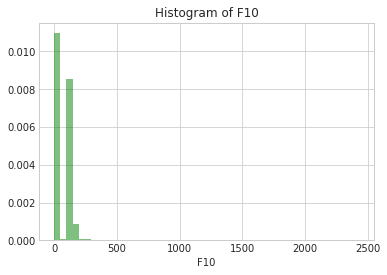

In [135]:
#data = zeroMean(data, column)
data.F10 -= data.F10.min()
data.F10 /= m.sqrt(data.F10.std())
pltHist(data, column)

In [136]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.020871
F12    0.020461
F4     0.015123
F16    0.011061
F6     0.010908
F7     0.003719
F17   -0.010492
F19   -0.012023
F3    -0.012033
F10   -0.018158
Name: Y, dtype: float64


Our correlation went up. ~~Lets take the log also and see if that helps.~~

In [137]:
#data.F10 = np.log(data.F10 + 1)

In [138]:
#corr_matrix = data.corr()
#print(corr_matrix['Y'].sort_values(ascending=False))

#### F12
F12 is the same as F5, lets drop it.

In [139]:
data.drop('F12', axis=1, inplace=True)

#### F16

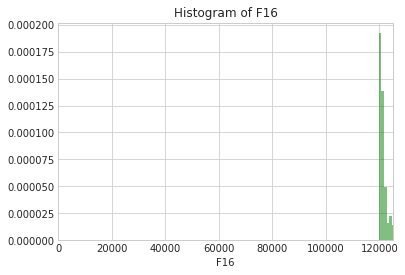

In [140]:
column = 'F16'
pltHist(data, column, num_bins=200)
_ = plt.xlim([0, 125000])

In [141]:
data[data[column] < 118000].count().F16

0

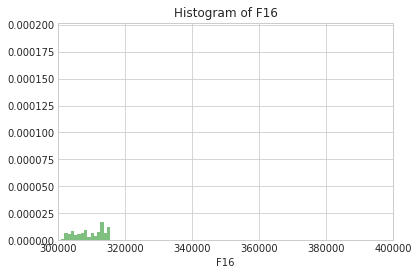

In [142]:
pltHist(data, column, num_bins=200)
_ = plt.xlim([300000, 400000])

In [143]:
data[data[column] > 320000].count().F16

0

In [144]:
data = zeroMean(data, column)

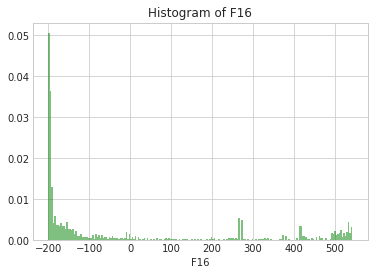

In [145]:
pltHist(data, column, num_bins=200)

In [146]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.020871
F4     0.015123
F16    0.011061
F6     0.010908
F7     0.003719
F17   -0.010492
F19   -0.012023
F3    -0.012033
F10   -0.018158
Name: Y, dtype: float64


F16's correlation with the labels actually decreased slightly. Not sure what to do to this column. I'm going to leave it for now.

#### F17

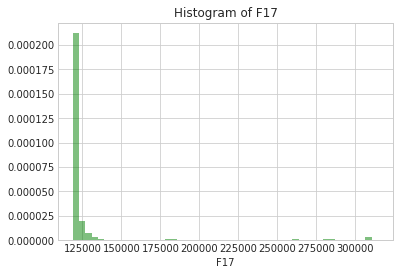

In [147]:
column = 'F17'
pltHist(data, column)

In [148]:
outliers = data[data[column] > 200000]
corr_matrix = outliers.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F4     0.040493
F17    0.021215
F10    0.003480
F5    -0.014851
F7    -0.017980
F19   -0.027720
F6    -0.056986
F3    -0.090701
F16   -0.103681
Name: Y, dtype: float64


Now that is interesting. The highest correlations I have seen so far are in the data points that are the outliers on this column. ~~Lets drop all those F17 outliers, log transform it, and zero mean it, and see what happens.~~

In [150]:
#data_copy = data[data[column] < 200000]
#data_copy = zeroMean(data_copy, column)
#data_copy['F17'] = np.log(data_copy['F17'])
#corr_matrix = data_copy.corr()
#print(corr_matrix['Y'].sort_values(ascending=False))

In [161]:
data.F17 -= data.F17.min()
data.F17 /= m.sqrt(data[column].std())
#data.F17 = np.exp(data.F17 + 1)

In [162]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.020871
F4     0.015123
F16    0.011061
F6     0.010908
F7     0.003719
F19   -0.012023
F3    -0.012033
F10   -0.018158
F17         NaN
Name: Y, dtype: float64


#### F19
Lets drop the outlier and shift it.

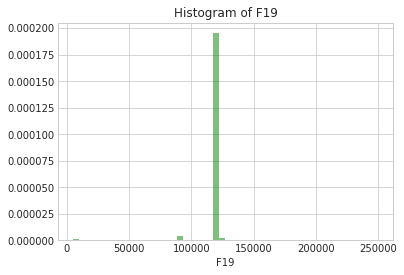

In [164]:
column = 'F19'
data = data[data.F19 < 300000]
pltHist(data, column)

In [165]:
data.F19 -= data.F19.mean()
data.F19 /= m.sqrt(data.F19.std())

In [166]:
corr_matrix = data.corr()
print(corr_matrix['Y'].sort_values(ascending=False))

Y      1.000000
F5     0.020817
F4     0.015114
F16    0.011068
F6     0.010905
F7     0.003727
F3    -0.012030
F19   -0.012408
F10   -0.018148
F17         NaN
Name: Y, dtype: float64
